In [280]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit
from numba.experimental import jitclass
import random
import math
plt.style.use("ggplot")

# Project 4: Gone (randomly?) viral
## MOD510 - University of Stavanger
#### Anne H. Amundsen and Aleksander B. Jakobsen
#### 13 December 2020

### Abstact
Include only the main highlights and results. What did we learn? 

### Introduction
Status of the problem and major objectives 

The aim of this project is to gain insights into how diseases spread. In a previous project \[1], the authors used continous compartment models to study the spread of disease. Compartmend models are commonly used when modelling infectious diseases to assign a population into compartements, where each compartement describe a specific state \[2]. The model used in \[1] assumed that every individual in a population interacted with the entire population, something which is not very realistic. Further, the outcome of the simulations in \[1] where the results of model input. Compartement models are commonly solved by differential equations, which are deterministic \[3]. While compartement models depicts important charectheristics of real data, there are other methods that can be used to model the transmission of infectious diseases. The focus of the current project is to implent Monte Carlo methods. 

Monte Carlo methods are named after the Monte Carlo Casino in Monaco, because of the roulettes in the casinoes and the need to generate random numbers \[4]. Monte Carlo methods are a class of computational algorithms which rely on random sampling to acheive numerical results \[5]. 

Mathematical modelling is of great importance when studying biological phenomenons. Models can take various forms, but the most widely used in the field of biological phenomenons are based on the random walk process \[6]. In this project, we will model how a disease spreads in a population by tracking each individual. Interactions between sick and healthy will be described by a random walk. This enables easy implementation and testing of various model assumptions. For a given model setup, we aim to simulate many steps forward in time, in order to compute statistics. This is the Monte Carlo component \[3]. 

In \[1], two important parameters in the compartement model approach where $\beta$, describing the effective rate of infection, and $\gamma$, describing the infection recovery rate. These two parameters gave $\mathcal{R}_0$, the basic reproduction number. However, in \[1], $\beta$ was assumed to decrease exponentially with time, and thus yielding an end to the pandemic. This does not accuratly represent how the 

These where key parameters in the compartement model approach. 


The 
The most common Monte Carlo sampling methods is 


there are  , and the models depicts key aspects of real data. However, there are other, more realistic, methods    

#### References
\[1] : Our previous projec 

\[2] : https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology#The_SEIR_model 

\[3]: prosjektbeskrivelse

\[4]: boken, side 126. 

\[5]: https://en.wikipedia.org/wiki/Monte_Carlo_method

\[6] royal society


### Exercise 1: Implement a random walk disease model

We start the project by assuming that there only are two possible disease states (meaning two compartements):

1. Sucpetible (S): Healthy persons who stand the chance of becoming sick.
2. Infectious (I): People that have the disease, and are contagious to others.

We wish to implement a random walk disease model in Python with the following criterias: 
- The walkers are assumed to move randomly (i.e., with a 25 percent chance) in one of the following four directions: North, South, East, or West. That is, walker goes either in the x-direction or in the y-direction, but not both at the same time.
- At the end of a time step, after having moved each walker, check for new infections.
- Every infectious individual will have the same probability, $q$, of infecting each susceptible person present at the same location. Go through each S-I pair in turn, and update the status of each newly infected person from $S$ to $I$.

We begin by implementing a random walk epidemic simulator:

In [416]:
class RandomWalkEpidemicSimulator:
    """
    Class used to model the spreading of a contagious disease in a
    population of individuals with a 2D random walk.

    Each walker has a disease status which is represented by an 
    integer Enum. Also, a set of integer (x, y)-coordinates are 
    stored for each walker. The possible coordinates are:

        {0, 1, ..., Lx-1} in the x-direction
        {0, 1, ..., Ly-1} in the y-direction

    It is only possible to move North, South, East, or West. If a 
    walker attempts to move outside of the physical domain, nothing 
    happens (i.e., a "bounce-back boundary condition" is enforced).
    """
    def __init__(self,
                 population_size,
                 no_init_infected=1,
                 nx=50,
                 ny=50,
                 q=0.9,
                 latency = False):
        """
        :param population_size: The total number of people (N).
        :param no_init_infected: The number of infected people at t=0.
        :param nx: The number of lattice nodes in the x-direction 
        :param ny: The number of lattice nodes in the y-direction.
        :param q: The probability of infection (0 <= q <= 1).
        """
        self.N_ = population_size
        self.I0_= no_init_infected
        self.nx_= nx
        self.ny_= ny
        self.infection_probability_ = q
        
        self.latency = latency
        
        #Position of Walkers
        self.Walkers_ = np.random.randint(0,
                                         [self.nx_, self.ny_],
                                         size = (self.N_, 2))
        
        self.Walkers_Old_ = self.Walkers_.copy()
        
        self.SUSCEPTIBLE_ = 0
        #self.EXSPOSED
        self.INFECTIOUS_ = 1
        self.RECOVERED_ = 2
        self.DEAD_ = 3
        self.State_ = np.full(self.N_, self.SUSCEPTIBLE_)
        self.State_[0:self.I0_] = self.INFECTIOUS_
        
        #Save states
        self.SUSCEPTIBLE_evol_ = []
        self.INFECTIOUS_evol_ = []
        self.DEAD_evol_ = []
            
        #Age
        self.age_class = np.random.choice([0, 1], size=self.N_, p=[0.5,0.5])
            
    def plot_current_state(self):
        S=self.Walkers_[self.State_ == self.SUSCEPTIBLE_]
        I=self.Walkers_[self.State_ == self.INFECTIOUS_]
        D=self.Walkers_[self.State_ == self.DEAD_]
        plt.figure()
        plt.scatter(I[:,0],I[:,1],c='r',s=80)
        plt.scatter(S[:,0],S[:,1],c='b')
        plt.scatter(D[:,0],D[:,1],c="black")
        #plot boundaries (walls):
        plt.axhline(y=0)
        plt.axhline(y=self.ny_)
        plt.axvline(x=0)
        plt.axvline(x=self.nx_)
        plt.xlim(-1,self.nx_+1)
        plt.ylim(-1,self.ny_+1)
        
    
    def move_walkers(self,age=False):
        if age: #code for is age is acivated
            next_pos = 2*np.random.randint(0,2,size=(self.N_,2))-1
            for pi in next_pos:
                pi[np.random.randint(0,2)]=0
            self.Walkers_ += next_pos
            for idx in range(self.N_):
                if self.is_at_illegal_position(self.Walkers_[idx]):
                    self.Walkers_[idx] = self.Walkers_Old_[idx]
                if self.age_class[idx] == 1:
                    if np.random.uniform() <= 0.2: #If less or equal to 0.2, then stay put (meaning stay put 20% of the times for old peeps)
                        self.Walkers_[idx] = self.Walkers_Old_[idx]
        
        else: #Code for when age is not activated
            next_pos = 2*np.random.randint(0,2,size=(self.N_,2))-1
            for pi in next_pos:
                pi[np.random.randint(0,2)]=0
            self.Walkers_ += next_pos
            for idx in range(self.N_):
                if self.is_at_illegal_position(self.Walkers_[idx]):
                    self.Walkers_[idx] = self.Walkers_Old_[idx]
                
   
    def is_at_illegal_position(self,c):
        #check x-coordinate:
        if c[0] < 0 or c[0] > self.nx_:
            return True
        #check y-coordinate:
        if c[1] < 0 or c[1] > self.ny_:
            return True
        

    def collide(self):
        meeting_points = self.meeting_locs()
        #print(meeting_points)
        if len(meeting_points) > 0:
            for m in meeting_points:
                is_at_m = (self.Walkers_[:, 0] == m[0]) & (self.Walkers_[:, 1] == m[1])
                idx_at_m = np.where(is_at_m)[0]
                states_at_m = self.State_[idx_at_m]
                is_sick = (states_at_m == self.INFECTIOUS_)
                is_healthy = (states_at_m == self.SUSCEPTIBLE_)
                idx_sick = idx_at_m[is_sick]
                idx_healthy = idx_at_m[is_healthy]
                for s in idx_sick:
                    for h in idx_healthy:
                        self.s_to_i(h)
 
    def meeting_locs(self):
        S=self.Walkers_[self.State_ == self.SUSCEPTIBLE_]
        I=self.Walkers_[self.State_ == self.INFECTIOUS_]
        S_x = np.array(S[:,0])
        S_y = np.array(S[:,1])
        I_x = np.array(I[:,0])
        I_y = np.array(I[:,1])
        S_cords = np.array([S_x,S_y])
        I_cords = np.array([I_x,I_y])
        S_cords = S_cords.T.copy().view([('',S_cords.dtype)]*2)
        I_cords = I_cords.T.copy().view([('',I_cords.dtype)]*2)
        meet_points = np.intersect1d(S_cords,I_cords)
        return meet_points
     
     
    def save_current_state(self):
        no_susceptible = np.sum(self.State_ == self.SUSCEPTIBLE_)
        no_infectious = np.sum(self.State_ == self.INFECTIOUS_)
        no_dead = np.sum(self.State_ == self.DEAD_)
        self.SUSCEPTIBLE_evol_.append(no_susceptible)
        self.INFECTIOUS_evol_.append(no_infectious)
        self.DEAD_evol_.append(no_dead)
    

    def simulate(self,steps,plot=False,age=False,death=False): #set death = true for ex 4
        for i in range(steps):
            self.move_walkers(age)
            if death:
                self.i_to_d()
            self.collide()
            self.save_current_state()
            
        if plot:
            self.plot_current_state()
            
    
    def s_to_i(self,index):
        #suceptible_to_infectious
        if np.random.uniform() < self.infection_probability_:
                self.State_[index] = self.INFECTIOUS_
            
    def i_to_d(self):
        #let some infected people die from the disease:
        death_prob = 0.022
        #draw 0.022 percent of infected and let them die
        no_infectious = np.sum(self.State_ == self.INFECTIOUS_)
        #if no_infectious > 1:  #Only start letting people die if there are more than 1 infected, so that we dont kill him before he starts a pandemic
        needs_to_die = round(death_prob * no_infectious) #number of peaople who needs to die is the total number of infectios times the death prob
        #Get index of walkers who have state infectious
        index = np.where(self.State_ == self.INFECTIOUS_)
        index_arr = np.array(index) #cast tuple to array
        #Now have the index of infectious people and know the amount of people who needs to die
        for i in range(needs_to_die):
            index_death = np.random.choice(index_arr.flatten())
            self.State_[index_death] = self.DEAD_
        #print(index_death)
        
            
    def reset_model(self):
        self.Walkers_ = np.random.randint(0,
                                         [self.nx_, self.ny_],
                                         size = (self.N_, 2))
        self.Walkers_Old_ = self.Walkers_.copy()
        self.State_ = np.full(self.N_, self.SUSCEPTIBLE_)
        self.State_[0:self.I0_] = self.INFECTIOUS_
        
    def beta(self):
        #Note: Requires that a simulation has been run first
        S = self.SUSCEPTIBLE_evol_
        I = self.INFECTIOUS_evol_
        N = self.N_
        beta = np.zeros(len(S))
        for i in range(1,len(S)):
            if S[i] == 0:
                beta[i] = float("NaN")
            else:
                beta[i] = -((S[i] - S[i-1])*N)/(S[i]*I[i])
        return beta
            
        
    

In [422]:
rw_test = RandomWalkEpidemicSimulator(population_size=683,
                                     nx = 50,
                                     ny = 50,
                                     q=0.9)



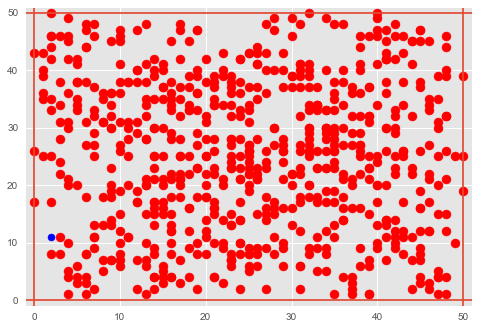

In [423]:
simulation_length = 300 #300
rw_test.simulate(simulation_length,plot=True)
#print(len(rw_test.INFECTIOUS_evol_))

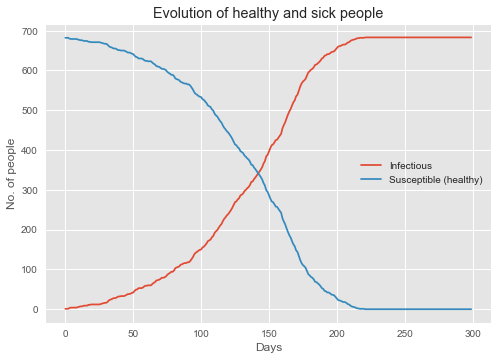

In [115]:
x_axis = np.arange(0,simulation_length)

plt.plot(x_axis,rw_test.INFECTIOUS_evol_,label="Infectious")
plt.plot(x_axis,rw_test.SUSCEPTIBLE_evol_,label="Susceptible (healthy)")
plt.title("Evolution of healthy and sick people")
plt.xlabel("Days")
plt.ylabel("No. of people")
plt.legend(loc=7)

From the above figure we see the evolution of healthy (blue curve) and infectious (red curve) people for a population of 683, given a grid size of 50 $\cdot$ 50. The simulation time is set to 300 (days). The relation between the two are inverse, as this is a closed comparetement model, meaning that is some amount of new persons becomes infectious, the healthy compartement will be reduced accordingly. We clearly see this by the symmetry of the plot.  

### Exercise 2: Comparison with deterministic SI-model

We start by studying the variation/uncertanty of the model. This is done by running the simulation from the previous part 100 times. For each time step, we calculate the sample mean and the sample standard deviation of the number of healthy and sick people.

In [154]:
no_sims = 100 #Number of simulations
steps = 300 #Number of steps
population = 683 #Population size
init_infect = 1 #Initial number of infectious people

#Susceptible matrix to store each step of each simulation in:
s_matrix = np.empty(shape=(steps,no_sims),dtype=float) #Number of colums = number of simulations. Number of rows = steps  

#Infection matrix
i_matrix = np.empty(shape=(steps,no_sims),dtype=float)
#print(i_matrix.shape)

#Conduct 100 simulations and store 
for i in range(no_sims):
    current_model = RandomWalkEpidemicSimulator(population_size=population, no_init_infected=init_infect, nx = 50, ny = 50, q=0.9)
    current_model.simulate(steps)
    s_matrix[:,i] = current_model.SUSCEPTIBLE_evol_
    i_matrix[:,i] = current_model.INFECTIOUS_evol_
    current_model.reset_model()


Now the `s_matrix` and `i_matrix` contains the 100 sumulations, where each of the 300 time steps have been stored. We can now calculate the sample mean and standard deviation of number of healthy and sick people. 

In [155]:
s_means_1 = s_matrix.mean(1)
s_std_1 = s_matrix.std(1)
i_means_1 = i_matrix.mean(1)
i_std_1 = i_matrix.std(1)

Text(0.5, 1.0, 'Expected time developement')

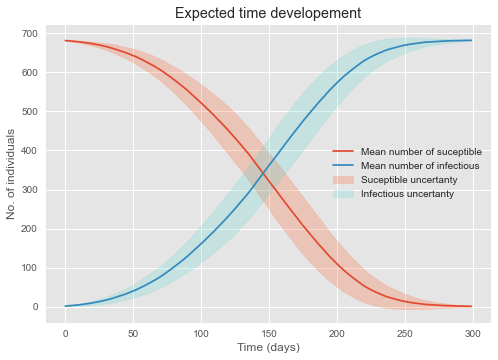

In [156]:
timeline = np.arange(0,steps,1)
plt.plot(timeline,s_means_1,label="Mean number of suceptible")
plt.fill_between(timeline,s_means_1-s_std_1,s_means_1+s_std_1,alpha=0.2,color="orangered",label="Suceptible uncertanty")
plt.plot(timeline,i_means_1,label="Mean number of infectious")
plt.fill_between(timeline,i_means_1-i_std_1,i_means_1+i_std_1,alpha=0.2,color="mediumturquoise",label="Infectious uncertanty")
plt.legend()
plt.xlabel("Time (days)")
plt.ylabel("No. of individuals")
plt.title("Expected time developement")

The above figure depicts the mean and uncertanty (measured by standard deviation) of the number of susceptible and infectious people in a population of 683 individuals based on a 50 $\cdot$ 50 simulation grid size. We see a clear trend in that the uncertanty shrinks at the end of the simulation period, meaning that at the end of the simulation, the entire population size will most likely be infected. 

##### Part 2:

Let's repeat the above simulation and visualization, except this time having initially 10 infectious individuals. 

Text(0.5, 1.0, 'Expected time developement')

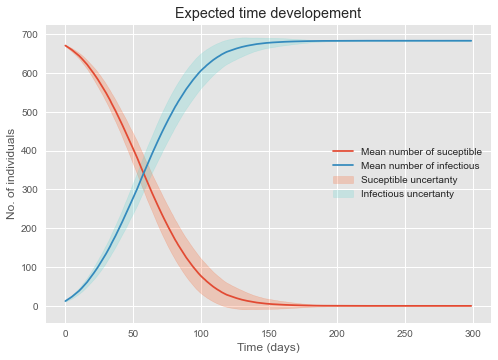

In [157]:
init_infect = 10 #Initial number of infectious people increased to 10

#Susceptible matrix to store each step of each simulation in:
s_matrix_2 = np.empty(shape=(steps,no_sims),dtype=float) #Number of colums = number of simulations. Number of rows = steps  

#Infection matrix
i_matrix_2 = np.empty(shape=(steps,no_sims),dtype=float)
#print(i_matrix.shape)

#Conduct 100 simulations and store
for i in range(no_sims):
    current_model = RandomWalkEpidemicSimulator(population_size=population, no_init_infected=init_infect, nx = 50, ny = 50, q=0.9)
    current_model.simulate(steps)
    s_matrix_2[:,i] = current_model.SUSCEPTIBLE_evol_
    i_matrix_2[:,i] = current_model.INFECTIOUS_evol_
    current_model.reset_model()
    
s_means_2 = s_matrix_2.mean(1)
s_std_2 = s_matrix_2.std(1)
i_means_2 = i_matrix_2.mean(1)
i_std_2 = i_matrix_2.std(1)

timeline = np.arange(0,steps,1)
plt.plot(timeline,s_means_2,label="Mean number of suceptible")
plt.fill_between(timeline,s_means_2-s_std_2,s_means_2+s_std_2,alpha=0.2,color="orangered",label="Suceptible uncertanty")
plt.plot(timeline,i_means_2,label="Mean number of infectious")
plt.fill_between(timeline,i_means_2-i_std_2,i_means_2+i_std_2,alpha=0.2,color="mediumturquoise",label="Infectious uncertanty")
plt.legend()
plt.xlabel("Time (days)")
plt.ylabel("No. of individuals")
plt.title("Expected time developement")

We see that when repeating the simulation with 10 initially infectious people, the time required to infect the entire population is significantly reduced. In the previous plot (1 initial infectious person), the amount of time required to infect the entire population was ~300 days. With 10 initially infectious people, the time required for the disease to infect the entire population is ~170 days, as seen in the figure. 

##### Part 3:

We now wish to compare the results from the two previous parts with the SZ-model used in Project 3. 

In [158]:
def I(N,I_0,Beta,t):
    S_0 = N - I_0
    return N/(1+(S_0/I_0)*np.exp(-Beta*t))

N = 683
I_0 = 1
Beta = 0.045

SI_model = np.empty(steps)
for i in range(steps):
    SI_model[i] = I(N,I_0,Beta,i)

Text(0.5, 1.0, 'Expected time developement')

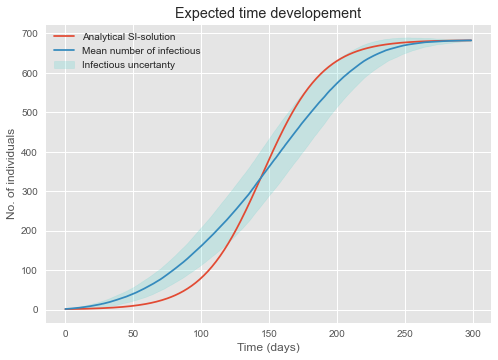

In [159]:
#Comparing with SI-model for 1 initially infectious person:
plt.plot(timeline,SI_model,label="Analytical SI-solution")
plt.plot(timeline,i_means_1,label="Mean number of infectious")
plt.fill_between(timeline,i_means_1-i_std_1,i_means_1+i_std_1,alpha=0.2,color="mediumturquoise",label="Infectious uncertanty")
plt.legend()
plt.xlabel("Time (days)")
plt.ylabel("No. of individuals")
plt.title("Expected time developement")

In the above figure, the developement of infectious persons versus time has been plotted with the analytical SI-model solution as well as the Random Walk (also displaying the uncertanty). The analytical solution had to be plotted several times to identify a $\beta$ value. For the case shown in the above figure (inital infectious = 1), $\beta$ was identified as 0.045.

Let us compare the analytical solution to the Random Walk for the case with 10 initially infectious persons:


Text(0.5, 1.0, 'Expected time developement')

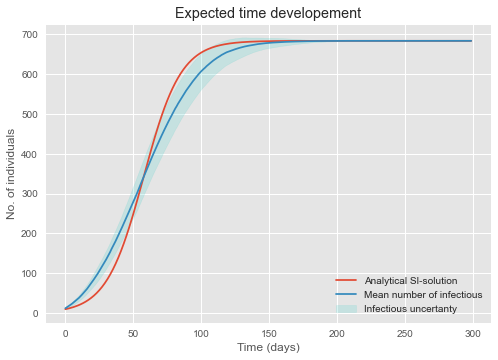

In [160]:
Beta = 0.073
I_0 = 10
SI_model = np.empty(steps)
for i in range(steps):
    SI_model[i] = I(N,I_0,Beta,i)


plt.plot(timeline,SI_model,label="Analytical SI-solution")
plt.plot(timeline,i_means_2,label="Mean number of infectious")
plt.fill_between(timeline,i_means_2-i_std_2,i_means_2+i_std_2,alpha=0.2,color="mediumturquoise",label="Infectious uncertanty")
plt.legend()
plt.xlabel("Time (days)")
plt.ylabel("No. of individuals")
plt.title("Expected time developement")

The above figure depicts the case when there are 10 initial infectious persons. Compared to the case when there is 1 initial infectious person, $\beta$ was here identified to 0.073 in order to match the Random Walk.

The two cases (initial infectious 1 and 10) illustrates that $\beta$ vary depending on the number of initial infectious individuals. 

### Exercise 3: Estimating parameters, and incorporating age classes

##### Part 1:

Our original $SI$-model was
\begin{align}
\tag{2}
\frac{\mathrm{d}S(t)}{\mathrm{d}t}&=-\beta(t)\cdot\frac{S(t)I(t)}{N} \,, \\ 
\tag{3}
\frac{\mathrm{d}I(t)}{\mathrm{d}t}&=\beta(t)\cdot\frac{S(t)I(t)}{N} \,.
\end{align}

In this model, $\beta(t)$ was input to the model. In the random walk model we
can <em>estimate</em> values for \( \beta \) based on observed changes in the random
walker population. To do this, we combine equation <a href="#mjx-eqn-2">(2)</a>
with a first order approximation of the derivative to yield:
$$
\begin{equation}
\beta\cdot\Delta t \approx -\frac{(S(t)-S(t-\Delta t))N}{S(t)I(t)},
\tag{4}
\end{equation}
$$

Use the formula above to estimate $\beta\cdot\Delta t$ from your estimated numbers of healthy $ S $, and infected $ I $ at each time step.

<ul>
<li> Estimate the mean and median of $\beta$, how well do these values compare with your value for $\beta$ in the previous exercise?</li>
</ul>

In [216]:
#Estimate beta for each simulation for each time step

#Using the case with 10 initial infectious
beta = np.empty(shape=(steps,no_sims),dtype=float)

for i in range(no_sims):
    current_model = RandomWalkEpidemicSimulator(population_size=population, no_init_infected=10, nx = 50, ny = 50, q=0.9)
    current_model.simulate(steps)
    beta[:,i] = current_model.beta()
    current_model.reset_model()

    

In [219]:
np.nanmean(beta)

0.06897455242113705

In [220]:
np.nanmedian(beta)

0.049129621637174506

We see that the mean $\beta$ for 100 simulations with 10 initial infecious individuals is ~0.069, while the median is ~0.049. The value found in Exercise 2 was 0.075. Therefore, the mean $\beta$ value from the simulations is a better match compared to the median. 

In [221]:
#Repeat in case when init infect is 1

beta = np.empty(shape=(steps,no_sims),dtype=float)

for i in range(no_sims):
    current_model = RandomWalkEpidemicSimulator(population_size=population, no_init_infected=1, nx = 50, ny = 50, q=0.9)
    current_model.simulate(steps)
    beta[:,i] = current_model.beta()
    current_model.reset_model()

In [222]:
np.nanmean(beta)

0.045759303548883024

In [223]:
np.nanmedian(beta)

0.026757556169320875

We find that the mean $\beta$ for 100 simulations when the number of initial infected individuals is set to 1 is ~0.046. In Exercise 2, $\beta$ was identified as 0.045 for this scenario. As in the case with 10 initially infected individuals, the mean is closer than the median to the identified value from Exercises 2. 

##### Part 2:

In this part we wish to record another property about each individual, namely their age class.

We implementat this by creating an array <code>age_class</code> and let <code>age_class[i]</code> denote the age of person number $i$.

<p>
For simplicity, we assume that there are only two age classes, young and old people:
    
   - 0 denotes young, so if person $i$ has `age_class` 0, then the person is young.
   - 1 denotes a old person, so if person $i$ has `age_class` 1, then the person is old.

We now modify the `move_walkers` part of the algorithm so that old people only have a 20 percent chance of moving in each of the four directions, and a 20 percent chance of staying put.  

In [262]:
beta = np.empty(shape=(steps,no_sims),dtype=float)

for i in range(no_sims):
    current_model = RandomWalkEpidemicSimulator(population_size=population, no_init_infected=10, nx = 50, ny = 50, q=0.9)
    current_model.simulate(steps,age=True) #Note, age has been implemented in the move walker function and is activated here
    beta[:,i] = current_model.beta()
    current_model.reset_model()

In [263]:
np.nanmean(beta)

0.07017971153778874

In [264]:
np.nanmedian(beta)

0.05319038471522766

For the case with 10 initial infecitous individuals, we see that the mean $\beta$ has a slight increase when the population is divided into age old and young, compared to the scenario when we did not consider age groups. The median value also increases. Now we redo the process for 1 initial infectious individual:

In [266]:
beta = np.empty(shape=(steps,no_sims),dtype=float)

for i in range(no_sims):
    current_model = RandomWalkEpidemicSimulator(population_size=population, no_init_infected=1, nx = 50, ny = 50, q=0.9)
    current_model.simulate(steps,age=True) #Note, age has been implemented in the move walker function and is activated here
    beta[:,i] = current_model.beta()
    current_model.reset_model()

In [267]:
np.nanmean(beta)

0.0486432173091112

In [268]:
np.nanmedian(beta)

0.02907248967777636

We see that the mean and median increases in this case as well. The increase is larger here than when initial infectious individuals were 10. 

### Exercise 4: Impementing our own scenarios

For the final part of the project, we are going to implement new features and our own scenarios for the model. 


**Death:** We start by implementing the fact that infected people might die. A function converting some percent of inceted people to dead people, `i_to_s()`, has been implemented in the class. To avoid issues with previous Exercises, the `simulate` function in the class has been updated to `simulate(self,steps,plot=False,age=False,death=False)`, meaning that if we wish to simulate with the possibility of walkers dying, one needs to set `death=True`when calling the simulation.  The `i_to_s()` identifies how many infectious walkers there are. Then, it assumes that 0.022 of these must die. It rounds the amount of required dead individuals to nearest whole walker. Then, it selects the respective amount of walkers at random and change their state from infectious to dead. The plot function in the class is also updated to plot dead individuals. Let us test: 

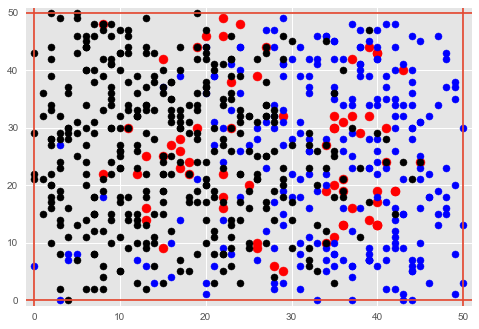

In [421]:
death = RandomWalkEpidemicSimulator(population_size=683,
                                     nx = 50,
                                     ny = 50,
                                     q=0.9)

death.simulate(300,plot=True,death=True)



We see that a large amount of the walkers die. Note that there are several walkers who have not been infected by the virus. In Exercise 1, where the same similulation was run without deaths, every walker became infected. The difference is that dead walkers stop moving, and can also not infect other individuals. Therefore, this slows the rate of infections.  Let us study the evolution of the compartements during this simulation: 

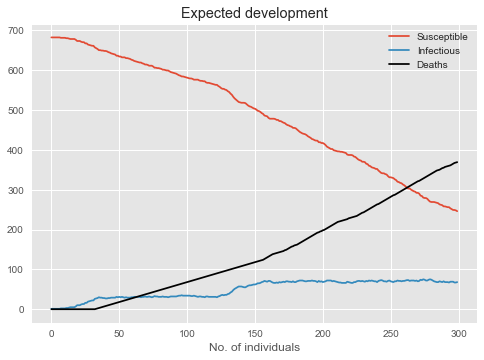

In [432]:
plt.plot(x_axis,death.SUSCEPTIBLE_evol_,label="Susceptible")
plt.plot(x_axis,death.INFECTIOUS_evol_,label="Infectious")
plt.plot(x_axis,death.DEAD_evol_,color="black",label="Deaths")
plt.xlabel("Time [days]")
plt.xlabel("No. of individuals")
plt.title("Expected development")
plt.legend()

In [244]:
np.random.choice([0, 1], size=10, p=[0.5,0.5])

array([0, 0, 0, 1, 0, 0, 0, 0, 1, 0])

In [236]:
len(s_matrix_2[1,:])

100

In [237]:
len(i_matrix[:,99])

300

In [410]:
# TEST CODE
arr = np.array([1, 0, 2, 0, 3, 4])
np.where(arr>0)[0]

idx_people_at_loc = np.array([0, 15, 33])

State_ = np.zeros(683, dtype=int)
State_[0] = 1
State_[15] = 1

state_at_loc = State_[idx_people_at_loc]
# print(state_at_loc)
is_sick = (state_at_loc == 1)
is_healthy = (state_at_loc == 0)
idx_sick = idx_people_at_loc[is_sick]
idx_healthy = idx_people_at_loc[is_healthy]

for i in idx_sick:
    for s in idx_healthy:
        

print(idx_healthy)
print(idx_sick)

IndentationError: expected an indented block (<ipython-input-410-27fe4e0c1043>, line 21)

In [467]:
arr = np.array([1, 0, 2, 0, 3, 4])
np.where(arr>0)[0]


array([0, 2, 4, 5], dtype=int64)

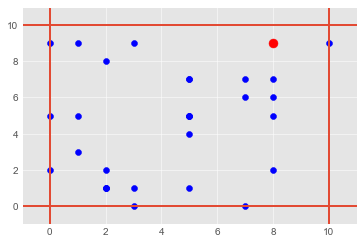

In [418]:
#rw_test.move_walkers()
#rw_test.collide()
rw_test.plot_current_state()
    

In [419]:
rw_test.move_walkers()
rw_test.collide()
rw_test.plot_current_state()

NameError: name 'meeting_locs' is not defined

In [420]:
rw_test.move_walkers()
rw_test.collide()
rw_test.plot_current_state()

NameError: name 'meeting_locs' is not defined

[]


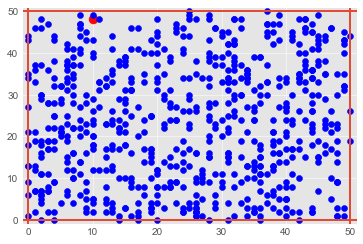

In [305]:
rw_test.move_walkers()
rw_test.collide()
rw_test.plot_current_state()

[]


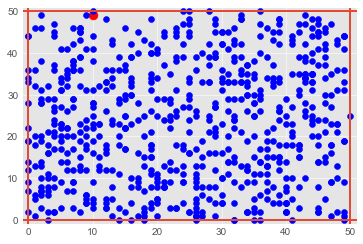

In [306]:
rw_test.move_walkers()
rw_test.collide()
rw_test.plot_current_state()

[]


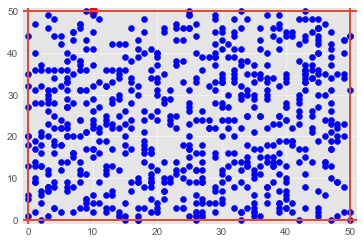

In [307]:
rw_test.move_walkers()
rw_test.collide()
rw_test.plot_current_state()

[]


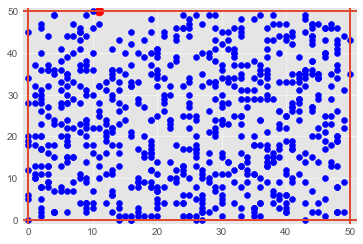

In [308]:
rw_test.move_walkers()
rw_test.collide()
rw_test.plot_current_state()

[]


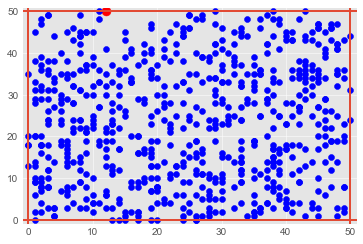

In [309]:
rw_test.move_walkers()
rw_test.collide()
rw_test.plot_current_state()

[]


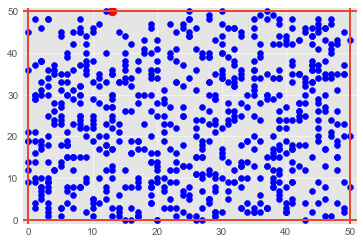

In [310]:
rw_test.move_walkers()
rw_test.collide()
rw_test.plot_current_state()

[]


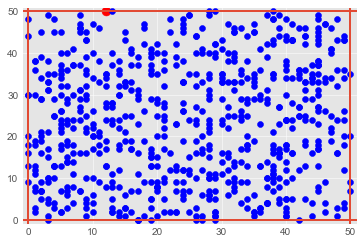

In [311]:
rw_test.move_walkers()
rw_test.collide()
rw_test.plot_current_state()

[(11, 47)]
Itemindex: (array([76], dtype=int64), array([0], dtype=int64))
S: [[38 10]
 [25  3]
 [16  0]
 ...
 [ 5 23]
 [39 45]
 [39  3]]
[76]
[0]


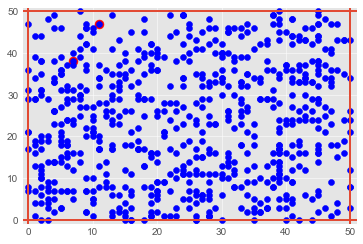

In [312]:

rw_test.move_walkers()
rw_test.plot_current_state()
rw_test.collide()

[(6, 38)]
Itemindex: (array([282], dtype=int64), array([0], dtype=int64))
S: [[37 10]
 [26  3]
 [17  0]
 ...
 [ 5 24]
 [38 45]
 [39  2]]
[282]
[0]


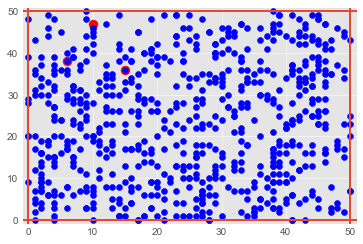

In [313]:
rw_test.move_walkers()
rw_test.collide()
rw_test.plot_current_state()

[(14, 36)]
Itemindex: (array([310], dtype=int64), array([0], dtype=int64))
S: [[38 10]
 [27  3]
 [16  0]
 ...
 [ 6 24]
 [39 45]
 [38  2]]
[310]
[0]


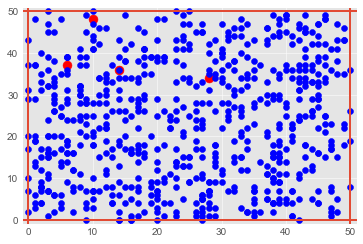

In [314]:
rw_test.move_walkers()
rw_test.collide()
rw_test.plot_current_state()

[(15, 36) (28, 33)]
Itemindex: (array([309], dtype=int64), array([0], dtype=int64))
S: [[39 10]
 [27  2]
 [17  0]
 ...
 [ 6 23]
 [38 45]
 [39  2]]
[309]
[0]
Itemindex: (array([429], dtype=int64), array([0], dtype=int64))
S: [[39 10]
 [27  2]
 [17  0]
 ...
 [ 6 23]
 [38 45]
 [39  2]]
[429]
[0]


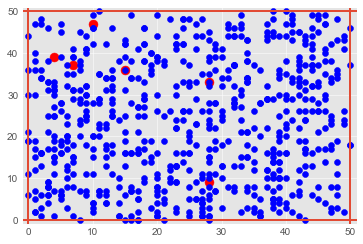

In [315]:
rw_test.move_walkers()
rw_test.collide()
rw_test.plot_current_state()

[( 8, 37) (10, 48) (27, 33)]
Itemindex: (array([451], dtype=int64), array([0], dtype=int64))
S: [[40 10]
 [28  2]
 [16  0]
 ...
 [ 6 24]
 [38 44]
 [38  2]]
[451]
[0]
Itemindex: (array([461], dtype=int64), array([0], dtype=int64))
S: [[40 10]
 [28  2]
 [16  0]
 ...
 [ 6 24]
 [38 44]
 [38  2]]
[461]
[0]
Itemindex: (array([427], dtype=int64), array([0], dtype=int64))
S: [[40 10]
 [28  2]
 [16  0]
 ...
 [ 6 24]
 [38 44]
 [38  2]]
[427]
[0]


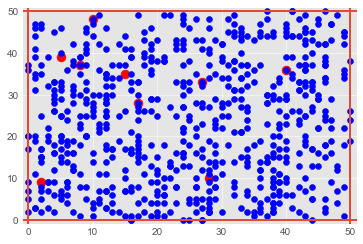

In [316]:
rw_test.move_walkers()
rw_test.collide()
rw_test.plot_current_state()

[(15, 36)]
Itemindex: (array([308], dtype=int64), array([0], dtype=int64))
S: [[40  9]
 [28  1]
 [16  1]
 ...
 [ 6 25]
 [39 44]
 [39  2]]
[308]
[0]


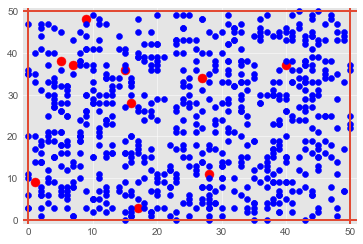

In [317]:
rw_test.move_walkers()
rw_test.collide()
rw_test.plot_current_state()

[(5, 37) (8, 37) (9, 49)]
Itemindex: (array([125], dtype=int64), array([0], dtype=int64))
S: [[39  9]
 [29  1]
 [16  0]
 ...
 [ 5 25]
 [39 43]
 [40  2]]
[125]
[0]
Itemindex: (array([661], dtype=int64), array([0], dtype=int64))
S: [[39  9]
 [29  1]
 [16  0]
 ...
 [ 5 25]
 [39 43]
 [40  2]]
[661]
[0]
Itemindex: (array([485], dtype=int64), array([0], dtype=int64))
S: [[39  9]
 [29  1]
 [16  0]
 ...
 [ 5 25]
 [39 43]
 [40  2]]
[485]
[0]


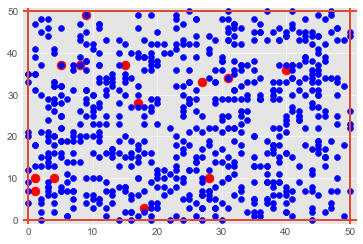

In [318]:
rw_test.move_walkers()
rw_test.collide()
rw_test.plot_current_state()

[( 4,  9) ( 4, 37) ( 7, 37) (19,  3)]
Itemindex: (array([354], dtype=int64), array([0], dtype=int64))
S: [[39 10]
 [29  2]
 [15  0]
 ...
 [ 6 25]
 [40 43]
 [40  3]]
[354]
[0]
Itemindex: (array([124], dtype=int64), array([0], dtype=int64))
S: [[39 10]
 [29  2]
 [15  0]
 ...
 [ 6 25]
 [40 43]
 [40  3]]
[124]
[0]
Itemindex: (array([658], dtype=int64), array([0], dtype=int64))
S: [[39 10]
 [29  2]
 [15  0]
 ...
 [ 6 25]
 [40 43]
 [40  3]]
[658]
[0]
Itemindex: (array([92], dtype=int64), array([0], dtype=int64))
S: [[39 10]
 [29  2]
 [15  0]
 ...
 [ 6 25]
 [40 43]
 [40  3]]
[92]
[0]


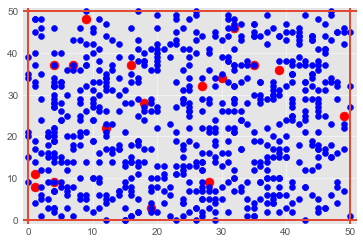

In [319]:
rw_test.move_walkers()
rw_test.collide()
rw_test.plot_current_state()

[( 5,  9) ( 7, 36) ( 9, 49) (18, 29) (19,  4) (32, 45)]
Itemindex: (array([351], dtype=int64), array([0], dtype=int64))
S: [[39 11]
 [29  1]
 [15  1]
 ...
 [ 7 25]
 [40 44]
 [40  2]]
[351]
[0]
Itemindex: (array([265, 654], dtype=int64), array([0, 0], dtype=int64))
S: [[39 11]
 [29  1]
 [15  1]
 ...
 [ 7 25]
 [40 44]
 [40  2]]
[265 654]
[0 0]
Itemindex: (array([480], dtype=int64), array([0], dtype=int64))
S: [[39 11]
 [29  1]
 [15  1]
 ...
 [ 7 25]
 [40 44]
 [40  2]]
[480]
[0]
Itemindex: (array([598], dtype=int64), array([0], dtype=int64))
S: [[39 11]
 [29  1]
 [15  1]
 ...
 [ 7 25]
 [40 44]
 [40  2]]
[598]
[0]
Itemindex: (array([91], dtype=int64), array([0], dtype=int64))
S: [[39 11]
 [29  1]
 [15  1]
 ...
 [ 7 25]
 [40 44]
 [40  2]]
[91]
[0]
Itemindex: (array([252], dtype=int64), array([0], dtype=int64))
S: [[39 11]
 [29  1]
 [15  1]
 ...
 [ 7 25]
 [40 44]
 [40  2]]
[252]
[0]


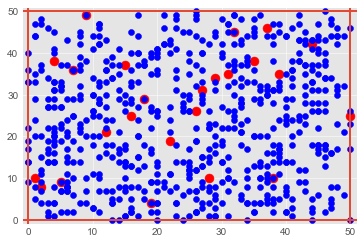

In [320]:
rw_test.move_walkers()
rw_test.collide()
rw_test.plot_current_state()

[( 4,  9) (10, 49) (16, 24) (26, 31) (34, 38) (38, 11) (38, 46)]
Itemindex: (array([625], dtype=int64), array([0], dtype=int64))
S: [[38 11]
 [30  1]
 [16  1]
 ...
 [ 8 25]
 [41 44]
 [39  2]]
[625]
[0]
Itemindex: (array([475], dtype=int64), array([0], dtype=int64))
S: [[38 11]
 [30  1]
 [16  1]
 ...
 [ 8 25]
 [41 44]
 [39  2]]
[475]
[0]
Itemindex: (array([443], dtype=int64), array([0], dtype=int64))
S: [[38 11]
 [30  1]
 [16  1]
 ...
 [ 8 25]
 [41 44]
 [39  2]]
[443]
[0]
Itemindex: (array([518], dtype=int64), array([0], dtype=int64))
S: [[38 11]
 [30  1]
 [16  1]
 ...
 [ 8 25]
 [41 44]
 [39  2]]
[518]
[0]
Itemindex: (array([259], dtype=int64), array([0], dtype=int64))
S: [[38 11]
 [30  1]
 [16  1]
 ...
 [ 8 25]
 [41 44]
 [39  2]]
[259]
[0]
Itemindex: (array([0], dtype=int64), array([0], dtype=int64))
S: [[38 11]
 [30  1]
 [16  1]
 ...
 [ 8 25]
 [41 44]
 [39  2]]
[0]
[0]
Itemindex: (array([368], dtype=int64), array([0], dtype=int64))
S: [[38 11]
 [30  1]
 [16  1]
 ...
 [ 8 25]
 [41 44]


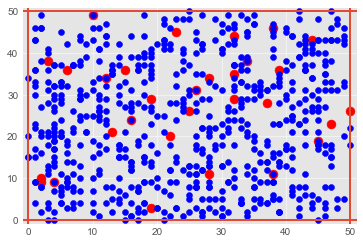

In [321]:
rw_test.move_walkers()
rw_test.collide()
rw_test.plot_current_state()

[( 2, 11) ( 4,  8) (12, 35) (19,  2) (23, 46) (25, 31) (32, 36) (32, 45)
 (39, 46)]
Itemindex: (array([186], dtype=int64), array([0], dtype=int64))
S: [[38 10]
 [31  1]
 [15  1]
 ...
 [ 8 26]
 [41 43]
 [39  1]]
[186]
[0]
Itemindex: (array([371, 619], dtype=int64), array([0, 0], dtype=int64))
S: [[38 10]
 [31  1]
 [15  1]
 ...
 [ 8 26]
 [41 43]
 [39  1]]
[371 619]
[0 0]
Itemindex: (array([365], dtype=int64), array([0], dtype=int64))
S: [[38 10]
 [31  1]
 [15  1]
 ...
 [ 8 26]
 [41 43]
 [39  1]]
[365]
[0]
Itemindex: (array([216], dtype=int64), array([0], dtype=int64))
S: [[38 10]
 [31  1]
 [15  1]
 ...
 [ 8 26]
 [41 43]
 [39  1]]
[216]
[0]
Itemindex: (array([502], dtype=int64), array([0], dtype=int64))
S: [[38 10]
 [31  1]
 [15  1]
 ...
 [ 8 26]
 [41 43]
 [39  1]]
[502]
[0]
Itemindex: (array([513], dtype=int64), array([0], dtype=int64))
S: [[38 10]
 [31  1]
 [15  1]
 ...
 [ 8 26]
 [41 43]
 [39  1]]
[513]
[0]
Itemindex: (array([477], dtype=int64), array([0], dtype=int64))
S: [[38 10]
 [31

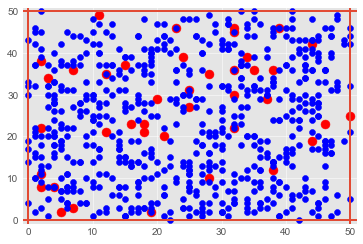

In [322]:
rw_test.move_walkers()
rw_test.collide()
rw_test.plot_current_state()

[( 2, 10) ( 3,  8) ( 7,  4) (11, 48) (12, 20) (12, 36) (16, 37) (17, 23)
 (18,  2) (31, 46) (32, 46) (34, 40) (35, 37) (38, 13) (39, 45) (43, 42)
 (45, 29)]
Itemindex: (array([ 13, 185], dtype=int64), array([0, 0], dtype=int64))
S: [[38  9]
 [31  2]
 [16  1]
 ...
 [ 8 25]
 [41 42]
 [40  1]]
[ 13 185]
[0 0]
Itemindex: (array([609], dtype=int64), array([0], dtype=int64))
S: [[38  9]
 [31  2]
 [16  1]
 ...
 [ 8 25]
 [41 42]
 [40  1]]
[609]
[0]
Itemindex: (array([ 52, 601], dtype=int64), array([0, 0], dtype=int64))
S: [[38  9]
 [31  2]
 [16  1]
 ...
 [ 8 25]
 [41 42]
 [40  1]]
[ 52 601]
[0 0]
Itemindex: (array([464], dtype=int64), array([0], dtype=int64))
S: [[38  9]
 [31  2]
 [16  1]
 ...
 [ 8 25]
 [41 42]
 [40  1]]
[464]
[0]
Itemindex: (array([157], dtype=int64), array([0], dtype=int64))
S: [[38  9]
 [31  2]
 [16  1]
 ...
 [ 8 25]
 [41 42]
 [40  1]]
[157]
[0]
Itemindex: (array([296], dtype=int64), array([0], dtype=int64))
S: [[38  9]
 [31  2]
 [16  1]
 ...
 [ 8 25]
 [41 42]
 [40  1]]
[29

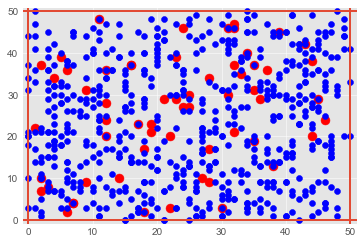

In [323]:
rw_test.move_walkers()
rw_test.collide()
rw_test.plot_current_state()

[( 1, 37) ( 3,  7) ( 6, 39) (11, 20) (11, 47) (16, 36) (17,  2) (17, 22)
 (19, 22) (30, 46) (33, 46) (36, 37) (39, 44) (44, 29)]
Itemindex: (array([501], dtype=int64), array([0], dtype=int64))
S: [[38  8]
 [30  2]
 [16  2]
 ...
 [ 8 24]
 [41 41]
 [40  0]]
[501]
[0]
Itemindex: (array([ 64, 589], dtype=int64), array([0, 0], dtype=int64))
S: [[38  8]
 [30  2]
 [16  2]
 ...
 [ 8 24]
 [41 41]
 [40  0]]
[ 64 589]
[0 0]
Itemindex: (array([417], dtype=int64), array([0], dtype=int64))
S: [[38  8]
 [30  2]
 [16  2]
 ...
 [ 8 24]
 [41 41]
 [40  0]]
[417]
[0]
Itemindex: (array([151], dtype=int64), array([0], dtype=int64))
S: [[38  8]
 [30  2]
 [16  2]
 ...
 [ 8 24]
 [41 41]
 [40  0]]
[151]
[0]
Itemindex: (array([425, 449], dtype=int64), array([0, 0], dtype=int64))
S: [[38  8]
 [30  2]
 [16  2]
 ...
 [ 8 24]
 [41 41]
 [40  0]]
[425 449]
[0 0]
Itemindex: (array([616], dtype=int64), array([0], dtype=int64))
S: [[38  8]
 [30  2]
 [16  2]
 ...
 [ 8 24]
 [41 41]
 [40  0]]
[616]
[0]
Itemindex: (array([37

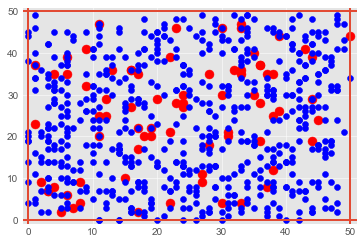

In [324]:
rw_test.move_walkers()
rw_test.collide()
rw_test.plot_current_state()

[( 1, 36) ( 3,  9) ( 4,  7) ( 6,  5) (11, 21) (13, 29) (13, 35) (14, 10)
 (16, 35) (17, 23) (20, 22) (24, 46) (27, 12) (29, 46) (32, 46) (33, 36)
 (33, 37) (38, 13) (38, 24) (39, 35) (44, 30) (44, 41)]
Itemindex: (array([487], dtype=int64), array([0], dtype=int64))
S: [[39  8]
 [30  3]
 [16  1]
 ...
 [ 8 23]
 [40 41]
 [40  5]]
[487]
[0]
Itemindex: (array([215], dtype=int64), array([0], dtype=int64))
S: [[39  8]
 [30  3]
 [16  1]
 ...
 [ 8 23]
 [40 41]
 [40  5]]
[215]
[0]
Itemindex: (array([573], dtype=int64), array([0], dtype=int64))
S: [[39  8]
 [30  3]
 [16  1]
 ...
 [ 8 23]
 [40 41]
 [40  5]]
[573]
[0]
Itemindex: (array([214], dtype=int64), array([0], dtype=int64))
S: [[39  8]
 [30  3]
 [16  1]
 ...
 [ 8 23]
 [40 41]
 [40  5]]
[214]
[0]
Itemindex: (array([473], dtype=int64), array([0], dtype=int64))
S: [[39  8]
 [30  3]
 [16  1]
 ...
 [ 8 23]
 [40 41]
 [40  5]]
[473]
[0]
Itemindex: (array([462], dtype=int64), array([0], dtype=int64))
S: [[39  8]
 [30  3]
 [16  1]
 ...
 [ 8 23]
 [40 

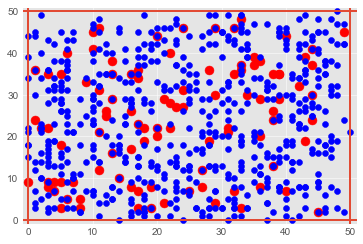

In [325]:
rw_test.move_walkers()
rw_test.collide()
rw_test.plot_current_state()

[( 2, 36) ( 3,  7) ( 3, 21) ( 4,  3) (11, 20) (14, 35) (16, 23) (17, 33)
 (23, 46) (25,  6) (28, 12) (29, 47) (32,  6) (32, 37) (36,  9) (38, 14)
 (38, 23) (40,  8) (40, 35) (42, 19) (46,  2) (49, 46)]
Itemindex: (array([467], dtype=int64), array([0], dtype=int64))
S: [[40  8]
 [30  2]
 [16  0]
 ...
 [ 7 23]
 [40 42]
 [40  4]]
[467]
[0]
Itemindex: (array([549], dtype=int64), array([0], dtype=int64))
S: [[40  8]
 [30  2]
 [16  0]
 ...
 [ 7 23]
 [40 42]
 [40  4]]
[549]
[0]
Itemindex: (array([72], dtype=int64), array([0], dtype=int64))
S: [[40  8]
 [30  2]
 [16  0]
 ...
 [ 7 23]
 [40 42]
 [40  4]]
[72]
[0]
Itemindex: (array([560], dtype=int64), array([0], dtype=int64))
S: [[40  8]
 [30  2]
 [16  0]
 ...
 [ 7 23]
 [40 42]
 [40  4]]
[560]
[0]
Itemindex: (array([140, 453], dtype=int64), array([0, 0], dtype=int64))
S: [[40  8]
 [30  2]
 [16  0]
 ...
 [ 7 23]
 [40 42]
 [40  4]]
[140 453]
[0 0]
Itemindex: (array([526], dtype=int64), array([0], dtype=int64))
S: [[40  8]
 [30  2]
 [16  0]
 ...
 [

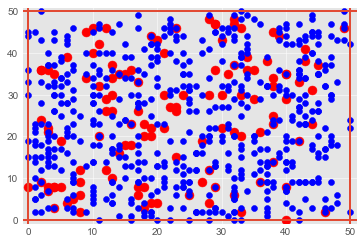

In [326]:
rw_test.move_walkers()
rw_test.collide()
rw_test.plot_current_state()

[( 4, 19) ( 4, 21) ( 4, 36) (10, 20) (12, 30) (14, 17) (14, 34) (15, 23)
 (17, 23) (18,  2) (18,  6) (18, 20) (28, 13) (29, 46) (32,  5) (32, 36)
 (32, 48) (37, 23) (39, 14) (39, 45) (46,  3)]
Itemindex: (array([422], dtype=int64), array([0], dtype=int64))
S: [[40  9]
 [29  2]
 [15  0]
 ...
 [ 6 23]
 [41 42]
 [41  4]]
[422]
[0]
Itemindex: (array([223], dtype=int64), array([0], dtype=int64))
S: [[40  9]
 [29  2]
 [15  0]
 ...
 [ 6 23]
 [41 42]
 [41  4]]
[223]
[0]
Itemindex: (array([372], dtype=int64), array([0], dtype=int64))
S: [[40  9]
 [29  2]
 [15  0]
 ...
 [ 6 23]
 [41 42]
 [41  4]]
[372]
[0]
Itemindex: (array([435], dtype=int64), array([0], dtype=int64))
S: [[40  9]
 [29  2]
 [15  0]
 ...
 [ 6 23]
 [41 42]
 [41  4]]
[435]
[0]
Itemindex: (array([309], dtype=int64), array([0], dtype=int64))
S: [[40  9]
 [29  2]
 [15  0]
 ...
 [ 6 23]
 [41 42]
 [41  4]]
[309]
[0]
Itemindex: (array([ 86, 488], dtype=int64), array([0, 0], dtype=int64))
S: [[40  9]
 [29  2]
 [15  0]
 ...
 [ 6 23]
 [41 4

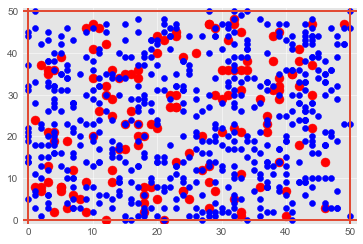

In [327]:
rw_test.move_walkers()
rw_test.collide()
rw_test.plot_current_state()